In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, make_scorer, r2_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
# load data 

df = pd.read_csv('Dataset Ph2 Cleaned.csv')

df.head()

,Indexno,AGE,GENDER,RCRI score,Anemia category,PreopEGFRMDRD,GradeofKidneydisease,DaysbetweenDeathandoperation,@30daymortality,Preoptransfusionwithin30days,...,SurgRiskCategory,RaceCategory,CVARCRICategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,RDW15.7,ASAcategorybinned,ICUAdmgt24h
0,111689,21,MALE,0,none,121.195820,G1,0.0,NO,0,...,Low,Chinese,no,no,no,no,no,<= 15.7,II,no
1,110169,20,MALE,1,moderate,124.312948,G1,0.0,NO,0,...,Moderate,Chinese,no,no,no,no,no,<= 15.7,IV-VI,yes
2,100897,29,MALE,0,none,81.442682,G2,0.0,NO,0,...,Low,Chinese,no,no,no,no,no,<= 15.7,I,no
3,2888,21,MALE,0,none,95.740830,G1,0.0,NO,0,...,Low,Others,no,no,no,no,no,<= 15.7,IV-VI,yes
4,113755,20,MALE,1,moderate,209.898261,G1,218.0,NO,0,...,Low,Chinese,no,no,no,no,no,>15.7,III,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11658 entries, 0 to 11657
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Indexno                       11658 non-null  int64  
 1   AGE                           11658 non-null  int64  
 2   GENDER                        11658 non-null  object 
 3   RCRI score                    11658 non-null  int64  
 4   Anemia category               11658 non-null  object 
 5   PreopEGFRMDRD                 11658 non-null  float64
 6   GradeofKidneydisease          11658 non-null  object 
 7   DaysbetweenDeathandoperation  11658 non-null  float64
 8   @30daymortality               11658 non-null  object 
 9   Preoptransfusionwithin30days  11658 non-null  int64  
 10  Intraop                       11658 non-null  int64  
 11  Postopwithin30days            11658 non-null  int64  
 12  Transfusionintraandpostop     11658 non-null  int64  
 13  A

In [5]:
df.describe()

,Indexno,AGE,RCRI score,PreopEGFRMDRD,DaysbetweenDeathandoperation,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop
count,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000,11658.000000
mean,58021.247041,54.412764,0.383170,96.787674,27.231429,0.084920,0.074284,0.028907,0.103191
std,33741.646354,16.569153,0.702413,35.569949,141.217260,0.600672,0.262243,0.323676,0.476510
min,10.000000,18.000000,0.000000,2.541026,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29181.500000,43.000000,0.000000,79.086322,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56974.000000,56.000000,0.000000,96.512521,0.000000,0.000000,0.000000,0.000000,0.000000
75%,85297.500000,67.000000,1.000000,115.102031,0.000000,0.000000,0.000000,0.000000,0.000000
max,121188.000000,99.000000,5.000000,588.466578,1783.000000,13.000000,1.000000,15.000000,16.000000


##### remove features

In [6]:
df = df.drop(columns=['Mortality','Indexno','RaceCategory','CVARCRICategory','PreopEGFRMDRD'],axis=1)

##### label encoder

In [7]:
cat_cols = [x for x in df.columns if df[x].dtype == 'object']
num_cols = [x for x in df.columns if df[x].dtype != 'object']
print(cat_cols)

['GENDER', 'Anemia category', 'GradeofKidneydisease', '@30daymortality', 'AnaestypeCategory', 'PriorityCategory', 'AGEcategory', 'SurgRiskCategory', 'IHDRCRICategory', 'CHFRCRICategory', 'DMinsulinRCRICategory', 'CreatinineRCRICategory', 'RDW15.7', 'ASAcategorybinned', 'ICUAdmgt24h']


In [8]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist='norm', plot=plt)
    plt.ylabel('\n' + variable + ' quantities')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


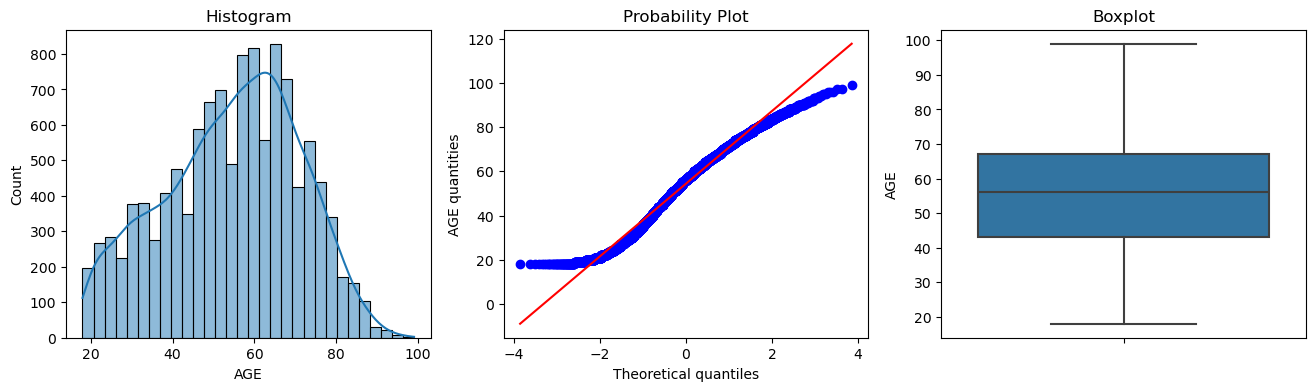

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


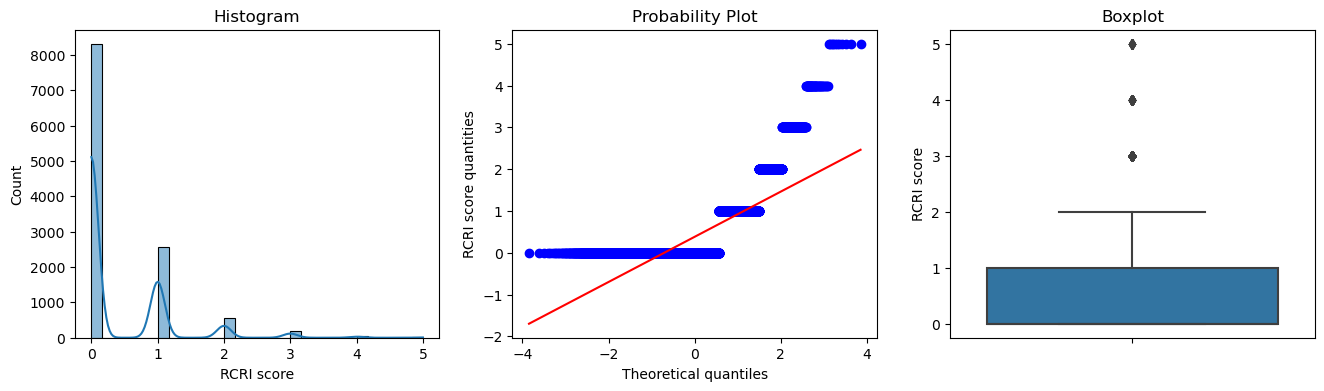

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


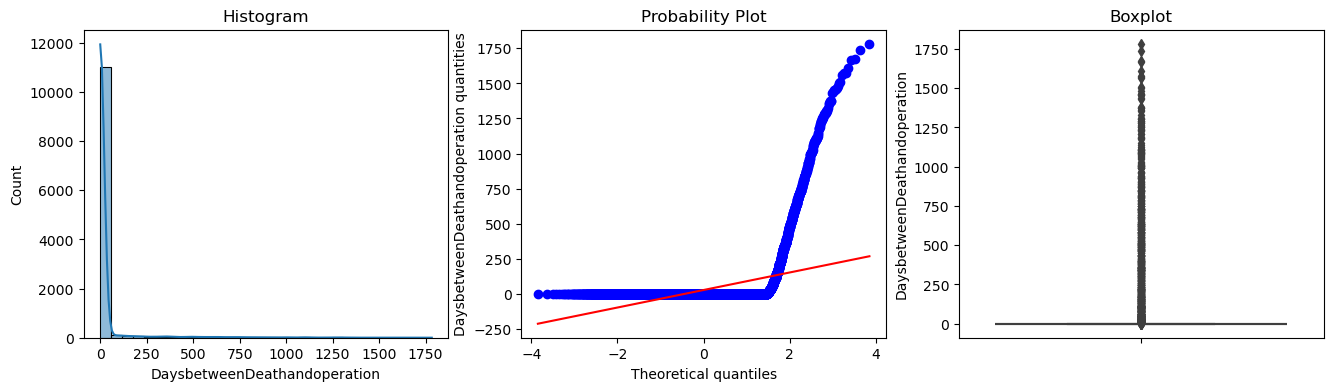

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


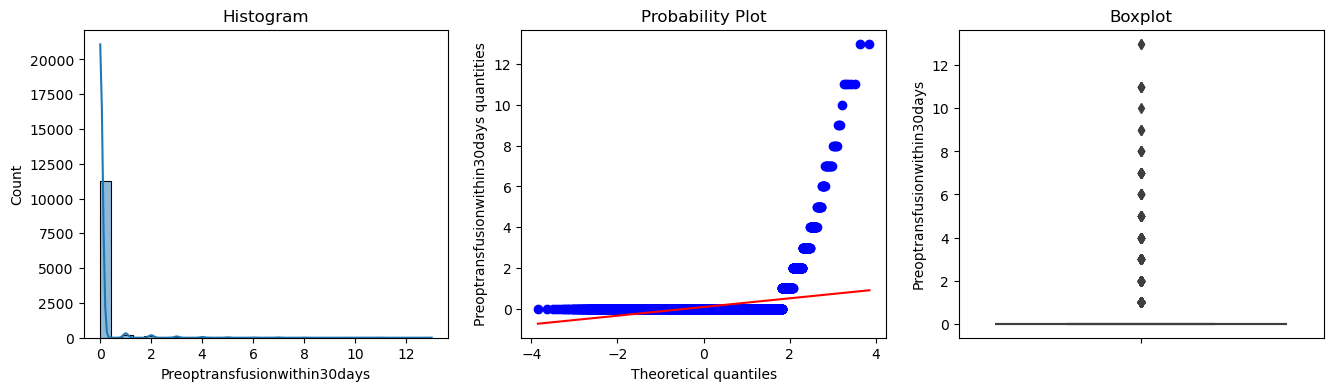

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


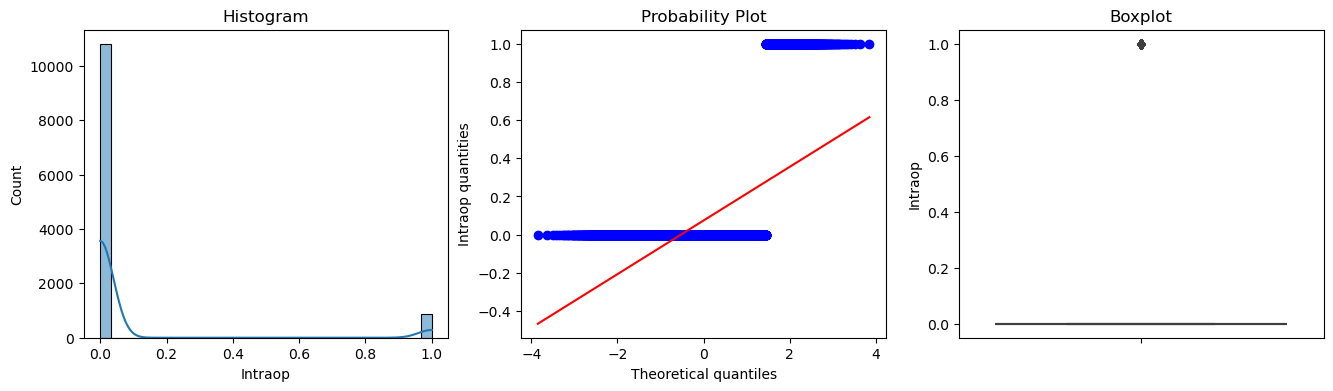

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


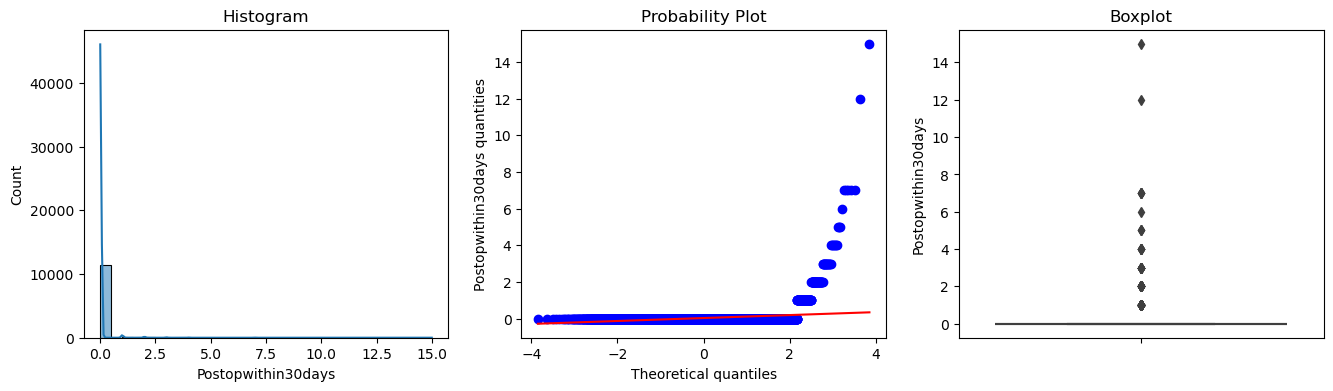

C:\Users\mikha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


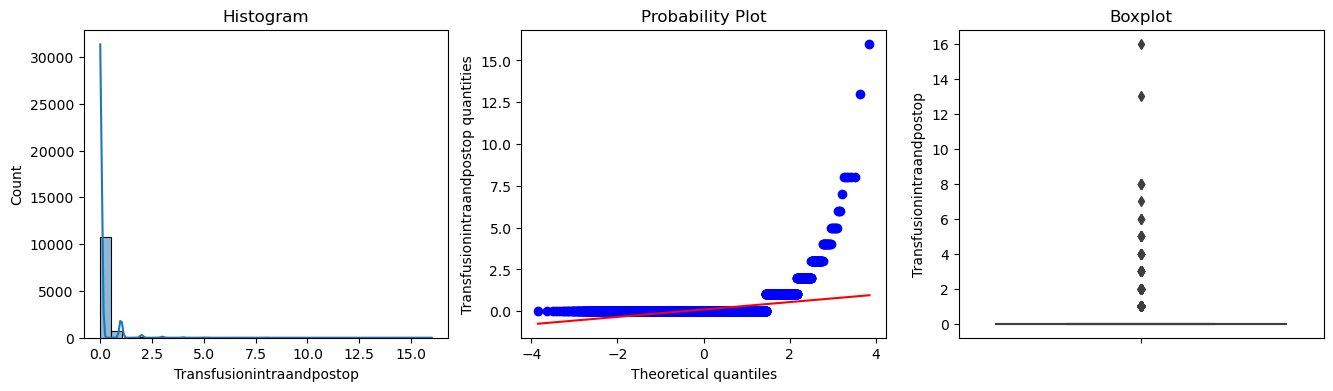

In [9]:
for col in num_cols:
    diagnostic_plots(df,col)

##### outliers

In [10]:
def trim_outliers(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Trim outliers
    trimmed_data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    return trimmed_data 

In [11]:
# df = trim_outliers(df,'PreopEGFRMDRD')
# diagnostic_plots(df,'PreopEGFRMDRD')

In [12]:
# df.shape

##### categorical encoding

In [13]:
label_enc = LabelEncoder()

print('encoded values : \n')

for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col])
    value_dict = {label: index for index, label in enumerate(label_enc.classes_)}
    print(f'{col} : {value_dict}')


encoded values : 

GENDER : {'FEMALE': 0, 'MALE': 1}
Anemia category : {'mild': 0, 'moderate': 1, 'none': 2, 'severe': 3}
GradeofKidneydisease : {'G1': 0, 'G2': 1, 'G3a': 2, 'G3b': 3, 'G4': 4, 'G5': 5}
@30daymortality : {'NO': 0, 'YES': 1}
AnaestypeCategory : {'GA': 0, 'RA': 1}
PriorityCategory : {'Elective': 0, 'Emergency': 1}
AGEcategory : {'18-29': 0, '30-49': 1, '50-64': 2, '65-74': 3, '75-84': 4, '>=85': 5}
SurgRiskCategory : {'High': 0, 'Low': 1, 'Moderate': 2}
IHDRCRICategory : {'no': 0, 'yes': 1}
CHFRCRICategory : {'no': 0, 'yes': 1}
DMinsulinRCRICategory : {'no': 0, 'yes': 1}
CreatinineRCRICategory : {'no': 0, 'yes': 1}
RDW15.7 : {'<= 15.7': 0, '>15.7': 1}
ASAcategorybinned : {'I': 0, 'II': 1, 'III': 2, 'IV-VI': 3}
ICUAdmgt24h : {'no': 0, 'yes': 1}


In [14]:
# move target variables to the end of dataframe

target_variables = ['@30daymortality', 'ICUAdmgt24h']

df = df[[col for col in df.columns if col not in target_variables] + target_variables]

df.head()

,AGE,GENDER,RCRI score,Anemia category,GradeofKidneydisease,DaysbetweenDeathandoperation,Preoptransfusionwithin30days,Intraop,Postopwithin30days,Transfusionintraandpostop,...,AGEcategory,SurgRiskCategory,IHDRCRICategory,CHFRCRICategory,DMinsulinRCRICategory,CreatinineRCRICategory,RDW15.7,ASAcategorybinned,@30daymortality,ICUAdmgt24h
0,21,1,0,2,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,20,1,1,1,0,0.0,0,0,0,0,...,0,2,0,0,0,0,0,3,0,1
2,29,1,0,2,1,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,21,1,0,2,0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,3,0,1
4,20,1,1,1,0,218.0,0,0,0,0,...,0,1,0,0,0,0,1,2,0,1


##### split and sample data

In [15]:
X = df.drop(columns=['@30daymortality'])  # features
y = df[['@30daymortality']]  # target variables


In [16]:
y.isnull().sum()

@30daymortality    0
dtype: int64

In [17]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [18]:
y_train['@30daymortality'].value_counts()

@30daymortality
0    8062
1      98
Name: count, dtype: int64

In [19]:
# under sample and oversample 

smoteenn = SMOTEENN(sampling_strategy=1, random_state=7)
X_train_oversampled, y_train_oversampled = smoteenn.fit_resample(X_train, y_train)

# under_sampler = RandomUnderSampler(sampling_strategy=1,random_state=7)
# X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

print('original shape of data : {} , {}'.format(X_train.shape, y_train.shape))
print('original value count: \n {} \n'.format(y_train.value_counts()))

print('after smoteenn shape of data : {} , {}'.format(X_train_oversampled.shape, y_train_oversampled.shape))
print('after smoteenn value count: \n {}'.format(y_train_oversampled.value_counts()))

# print('after undersampling shape of data : {} , {}'.format(X_train_undersampled.shape, y_train_undersampled.shape))
# print('after undersampling value count: \n {}'.format(y_train_undersampled.value_counts()))


original shape of data : (8160, 21) , (8160, 1)
original value count: 
 @30daymortality
0                  8062
1                    98
Name: count, dtype: int64 

after smoteenn shape of data : (16084, 21) , (16084, 1)
after smoteenn value count: 
 @30daymortality
1                  8062
0                  8022
Name: count, dtype: int64


In [20]:
X_train_resampled = X_train_oversampled
y_train_resampled = y_train_oversampled

In [21]:
y_train_resampled

,@30daymortality
0,0
1,0
2,0
3,0
4,0
...,...
16079,1
16080,1
16081,1
16082,1


In [22]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [23]:
y_train_resampled = np.ravel(y_train_resampled)

##### logistic regression

In [24]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs')

logreg.fit(X_train_resampled, y_train_resampled)


LogisticRegression()

In [25]:
y_fitted = logreg.predict(X_train_resampled) # returns 0 or 1
y_fitted_prob = logreg.predict_proba(X_train_resampled)[:,0] # returns probabilities

print(logreg.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(logreg.score(X_test, y_test), '(Test Accuracy)')

0.9177443422034319 (Train Accuracy)
0.8936535162950258 (Test Accuracy)


##### mlp

In [26]:
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=7)
# Fit the #### ANN Model#### ANN Modelmodel to the training set
mlp.fit(X_train_resampled,y_train_resampled)

MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=2000,
              random_state=7, solver='sgd')

In [27]:
print(mlp.coefs_)
print(mlp.intercepts_)

[array([[-0.39197857, -0.22083014, -0.13577733, -0.19104489,  0.70564238,
        -0.32810848,  0.01551488, -0.58859216,  0.27809066,  0.40557967],
       [ 0.22183702,  0.26295007, -0.00882292, -0.10367628, -0.36126381,
         0.2443871 , -0.14947337,  0.11880367,  0.14884996, -0.27366422],
       [-0.23711146, -0.30007328, -0.29724197, -0.32890754,  0.90054036,
        -0.65483585,  0.03016431, -0.3720227 ,  0.66125747,  0.4970045 ],
       [ 0.1311864 ,  0.34740293,  0.06279538,  0.48474658, -0.45648162,
         0.5114966 ,  0.12933241,  0.39352689, -0.53563094, -0.57480461],
       [-0.0462002 , -0.08183901,  0.07197173, -0.17330311, -0.15213804,
         0.15090944, -0.06464598,  0.13705001, -0.06299726,  0.14828414],
       [ 0.15065068,  0.3696382 ,  0.17022605,  0.30764574, -0.59526081,
        -0.08862175, -0.22483572,  0.41162932, -0.36227229, -0.36907093],
       [ 0.18708357, -0.14466102, -0.29876404, -0.2681324 ,  0.60773538,
        -0.38113204,  0.2266848 ,  0.0817984

In [28]:
# Calculated the fitted values for training set
y_fitted = mlp.predict(X_train_resampled) # returns 0 or 1
y_fitted_prob = mlp.predict_proba(X_train_resampled)[:,0] # returns probabilities

print(mlp.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(mlp.score(X_test, y_test), '(Test Accuracy)')

0.9146356627704552 (Train Accuracy)
0.8973699256718125 (Test Accuracy)


##### k fold cross validation

In [29]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# train_cv_scores = cross_val_score(mlp, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
# test_cv_scores = cross_val_score(mlp, X_test, y_test, cv=kf, scoring='accuracy')

# # Print the cross-validation scores for training set
# print("Cross-validation scores for training set:", train_cv_scores)

# # Print the cross-validation scores for test set
# print("Cross-validation scores for test set:", test_cv_scores)

In [30]:
# print("Mean accuracy for training set:", np.mean(train_cv_scores))
# print("Standard deviation of accuracy for training set:", np.std(train_cv_scores))
# print()
# # Calculate and print the mean and standard deviation of the cross-validation scores for test set
# print("Mean accuracy for test set:", np.mean(test_cv_scores))
# print("Standard deviation of accuracy for test set:", np.std(test_cv_scores))

##### model score

In [31]:
y_pred = mlp.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.08136482939632546
Recall: 0.775
F1-Score: 0.14726840855106887


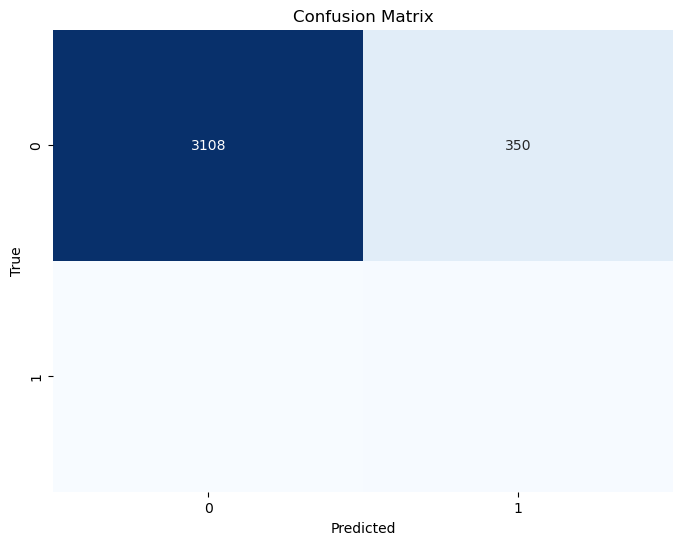

In [32]:
y_pred = mlp.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


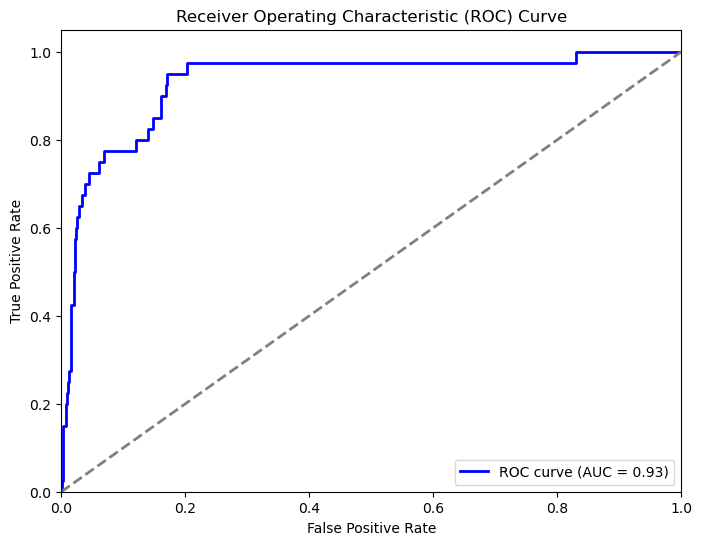

In [33]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = mlp.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Random Forest Classifier

In [34]:
rf_classifier = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=7)
rf_classifier.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(class_weight='balanced', random_state=7)

In [35]:
y_pred = rf_classifier.predict(X_test)


In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 99.97%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3458
           1       1.00      0.97      0.99        40

    accuracy                           1.00      3498
   macro avg       1.00      0.99      0.99      3498
weighted avg       1.00      1.00      1.00      3498



##### ICU admission

In [37]:
X = df.drop(columns=['ICUAdmgt24h'])  # features
y = df[['ICUAdmgt24h']]  # target variables

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)


In [38]:
y_train.value_counts()

ICUAdmgt24h
0              7653
1               507
Name: count, dtype: int64

In [39]:
smoteenn = SMOTEENN(sampling_strategy=0.5, random_state=7)
X_train_oversampled, y_train_oversampled = smoteenn.fit_resample(X_train, y_train)

under_sampler = RandomUnderSampler(random_state=7)
X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train_oversampled, y_train_oversampled)

print('original shape of data : {} , {}'.format(X_train.shape, y_train.shape))
print('original value count: \n {} \n'.format(y_train.value_counts()))

print('after smoteenn shape of data : {} , {}'.format(X_train_oversampled.shape, y_train_oversampled.shape))
print('after smoteenn value count: \n {}'.format(y_train_oversampled.value_counts()))

print('after undersampling shape of data : {} , {}'.format(X_train_undersampled.shape, y_train_undersampled.shape))
print('after undersampling value count: \n {}'.format(y_train_undersampled.value_counts()))

original shape of data : (8160, 21) , (8160, 1)
original value count: 
 ICUAdmgt24h
0              7653
1               507
Name: count, dtype: int64 

after smoteenn shape of data : (9830, 21) , (9830, 1)
after smoteenn value count: 
 ICUAdmgt24h
0              6413
1              3417
Name: count, dtype: int64
after undersampling shape of data : (6834, 21) , (6834, 1)
after undersampling value count: 
 ICUAdmgt24h
0              3417
1              3417
Name: count, dtype: int64


In [40]:
X_train_resampled = X_train_undersampled
y_train_resampled = y_train_undersampled

In [41]:
X_train_resampled.shape , y_train_resampled.shape

((6834, 21), (6834, 1))

In [42]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [43]:
y_train_resampled = np.ravel(y_train_resampled)


In [44]:
mlp = MLPClassifier(activation ='logistic', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=7)
# Fit the #### ANN Model#### ANN Modelmodel to the training set
mlp.fit(X_train_resampled,y_train_resampled)

MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), max_iter=2000,
              random_state=7, solver='sgd')

In [45]:
y_fitted = mlp.predict(X_train_resampled) # returns 0 or 1
y_fitted_prob = mlp.predict_proba(X_train_resampled)[:,0] # returns probabilities

print(mlp.score(X_train_resampled, y_train_resampled), '(Train Accuracy)')
print(mlp.score(X_test, y_test), '(Test Accuracy)')

0.8810359964881475 (Train Accuracy)
0.8290451686678102 (Test Accuracy)


##### random forest

In [46]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=7)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=7)

In [47]:
y_pred = rf_classifier.predict(X_test)


In [48]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 84.88%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      3296
           1       0.24      0.78      0.37       202

    accuracy                           0.85      3498
   macro avg       0.61      0.82      0.64      3498
weighted avg       0.94      0.85      0.88      3498



##### multi output classifier (idk)
- class is imbalanced

In [49]:
X = df.drop(columns=['ICUAdmgt24h','@30daymortality'])  # features
y = df[['ICUAdmgt24h','@30daymortality']]  # target variables


In [50]:
y['ICUAdmgt24h'].value_counts()

ICUAdmgt24h
0    10949
1      709
Name: count, dtype: int64

In [51]:
y['@30daymortality'].value_counts()

@30daymortality
0    11520
1      138
Name: count, dtype: int64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)


In [53]:
## sampling 

In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [55]:
#instantiate model
clf = MultiOutputClassifier(LogisticRegression(solver='liblinear'))
clf.fit(X_train, y_train) #fit model


preds = clf.predict(X_test) #predict target

#get model score
clf.score(X_train,y_train)


0.941421568627451

In [56]:
clf.score(X_test,y_test)

0.9491137793024585